# Author imformation:
Fan Shengzhe, Shanghaijiaotong University, Shanghai, China  
Email: fanshengzhe@sjtu.edu.cn

# 1.读取数据

## 1.1 基本数据的读取

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("drive/My Drive/reco/agri-machine-reco")

In [ ]:
import pandas as pd
import os
import json
import tqdm

data_dir = './cache'
save_dir = './cache'


if not os.path.exists(save_dir):
  os.mkdir(save_dir)

user_item_label_df = pd.read_csv(os.path.join(data_dir, 'user_item_rank_feats_df.csv'))
user_item_label_df = user_item_label_df.rename(columns={'score': 'recall_score'})

In [ ]:
user_item_label_df.columns

Index(['user_id', 'item_id', 'recall_score', 'label', 'event_time', 'region',
       'price', 'user_session', 'is_nan_region', 'year',
       ...
       'rc_c_diff_u_pos_weight_mode_region', 'ctx_diff_last_ua_ctx_event_time',
       'ctx_diff_last_ua_ctx_price', 'ctx_diff_last_ua_ctx_year',
       'ctx_diff_last_ua_ctx_month', 'ctx_diff_last_ua_ctx_season',
       'ctx_diff_last_ua_ctx_yearday', 'ctx_diff_last_ua_ctx_region',
       'ctx_diff_last_ua_ctx_user_session',
       'ctx_diff_last_ua_ctx_is_nan_region'],
      dtype='object', length=156)

## 1.2 训练、验证集划分


In [ ]:
trn_user = pd.read_csv(os.path.join(data_dir, 'trn_user.csv'))
val_and_test_user = pd.read_csv(os.path.join(data_dir, 'val_user.csv'))
num_of_val_and_test_user = val_and_test_user['user_id'].nunique()
val_user = val_and_test_user.sample(frac=0.5, random_state=2022)
test_user = val_and_test_user[~val_and_test_user['user_id'].isin(val_user['user_id'])]

train_user_item_label_df = user_item_label_df[user_item_label_df['user_id'].isin(trn_user['user_id'])]
val_user_item_label_df = user_item_label_df[user_item_label_df['user_id'].isin(val_user['user_id'])]
test_user_item_label_df = user_item_label_df[user_item_label_df['user_id'].isin(test_user['user_id'])]

In [ ]:
user_item_label_df

,user_id,item_id,recall_score,label,event_time,region,price,user_session,is_nan_region,year,...,rc_c_diff_u_pos_weight_mode_region,ctx_diff_last_ua_ctx_event_time,ctx_diff_last_ua_ctx_price,ctx_diff_last_ua_ctx_year,ctx_diff_last_ua_ctx_month,ctx_diff_last_ua_ctx_season,ctx_diff_last_ua_ctx_yearday,ctx_diff_last_ua_ctx_region,ctx_diff_last_ua_ctx_user_session,ctx_diff_last_ua_ctx_is_nan_region
0,1,60,0.3030,4,1.555395e+09,6.0,0.08777,3.0,0.0,2019.0,...,1,16.0,0.000244,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,69,0.3804,2,1.514985e+09,0.0,0.08093,4.0,0.0,2018.0,...,1,63183.0,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,5,136,0.5490,4,1.515189e+09,NaN,0.08093,12.0,1.0,2018.0,...,1,-30.0,-0.003906,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7,191,0.1260,2,1.515043e+09,27.0,0.09070,16.0,0.0,2018.0,...,0,11691.0,0.000915,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,8,272,0.2441,2,1.529996e+09,NaN,0.11280,17.0,1.0,2018.0,...,0,629849.0,0.000000,0.0,0.0,0.0,8.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176680,54525,973,0.0000,1,1.609435e+09,33.0,0.09760,86232.0,0.0,2020.0,...,0,15687.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1176681,54525,2119,0.0000,1,1.609435e+09,33.0,0.09760,86232.0,0.0,2020.0,...,0,15687.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1176682,54525,3876,0.0000,1,1.609435e+09,33.0,0.09760,86232.0,0.0,2020.0,...,0,15687.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1176683,54525,371,0.0000,1,1.609435e+09,33.0,0.09760,86232.0,0.0,2020.0,...,0,15687.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0


# 2.LGBM Ranker

## 2.1 训练

In [ ]:
import lightgbm as lgb

In [ ]:
# 定义特征列
lgb_cols = list(user_item_label_df.columns)
lgb_cols.remove('label')

In [ ]:
# 排序模型分组
train_user_item_label_df = train_user_item_label_df.sort_values(by=['user_id'])
g_train = train_user_item_label_df.groupby(['user_id'], as_index=False).count()["label"].values

val_user_item_label_df = val_user_item_label_df.sort_values(by=['user_id'])
g_val = val_user_item_label_df.groupby(['user_id'], as_index=False).count()["label"].values

test_user_item_label_df = test_user_item_label_df.sort_values(by=['user_id'])
g_test = test_user_item_label_df.groupby(['user_id'], as_index=False).count()["label"].values

In [ ]:
# 排序模型定义
lgb_ranker = lgb.LGBMRanker(boosting_type='goss', num_leaves=100, reg_alpha=0.0, reg_lambda=0.0,
                max_depth=-1, n_estimators=1000, subsample=1, subsample_freq=0, colsample_bytree=0.7, 
                learning_rate=0.1, min_child_weight=5, random_state=2022, n_jobs=16, verbose=10)  

In [ ]:
# 排序模型训练
lgb_ranker.fit(train_user_item_label_df[lgb_cols], train_user_item_label_df['label'], group=g_train,
        eval_set=[(val_user_item_label_df[lgb_cols], val_user_item_label_df['label'])], 
        eval_group=[g_val], eval_at=[1, 2, 3, 4, 5], eval_metric=['ndcg'], early_stopping_rounds=50)

[1]	valid_0's ndcg@1: 0.858582	valid_0's ndcg@2: 0.877439	valid_0's ndcg@3: 0.889256	valid_0's ndcg@4: 0.896843	valid_0's ndcg@5: 0.902849	valid_0's ndcg@1: 0.858582	valid_0's ndcg@2: 0.877439	valid_0's ndcg@3: 0.889256	valid_0's ndcg@4: 0.896843	valid_0's ndcg@5: 0.902849
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's ndcg@1: 0.866629	valid_0's ndcg@2: 0.895013	valid_0's ndcg@3: 0.908351	valid_0's ndcg@4: 0.917443	valid_0's ndcg@5: 0.923291	valid_0's ndcg@1: 0.866629	valid_0's ndcg@2: 0.895013	valid_0's ndcg@3: 0.908351	valid_0's ndcg@4: 0.917443	valid_0's ndcg@5: 0.923291
[3]	valid_0's ndcg@1: 0.867687	valid_0's ndcg@2: 0.898827	valid_0's ndcg@3: 0.913152	valid_0's ndcg@4: 0.922364	valid_0's ndcg@5: 0.928106	valid_0's ndcg@1: 0.867687	valid_0's ndcg@2: 0.898827	valid_0's ndcg@3: 0.913152	valid_0's ndcg@4: 0.922364	valid_0's ndcg@5: 0.928106
[4]	valid_0's ndcg@1: 0.881291	valid_0's ndcg@2: 0.90617	valid_0's ndcg@3: 0.918784	valid_0's ndcg@4: 0.927016	valid

LGBMRanker(boosting_type='goss', colsample_bytree=0.7, min_child_weight=5,
           n_estimators=1000, n_jobs=16, num_leaves=100, random_state=2022,
           subsample=1, verbose=10)

## 2.3 预测和评估

In [ ]:
test_user_item_label_df['pred_score'] = lgb_ranker.predict(test_user_item_label_df[lgb_cols], num_iteration=lgb_ranker.best_iteration_)

In [ ]:
test_res_df = test_user_item_label_df[['user_id', 'item_id', 'pred_score', 'label']].\
            sort_values(['user_id', 'pred_score'], ascending=[True, False])

In [ ]:
import numpy as np
def get_ndcg(res_df, pred_name='pred', label_name='label', eval_at=[1, 2, 3, 4, 5, 10], need_print=True):

  def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


  def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)
    if not idcg:
        return 1.
    return dcg_at_k(r, k) / idcg

  res_df = res_df[['user_id', 'item_id', pred_name, label_name]].\
            sort_values(['user_id', pred_name], ascending=[True, False])
  ndcgs = [0] * len(eval_at)
  for index in range(len(eval_at)):
    ndcgs[index] = res_df.groupby('user_id')[label_name].apply(lambda x: ndcg_at_k(x, eval_at[index])).mean()

  if need_print:
    for index in range(len(eval_at)):
      print(' topk: ', eval_at[index], ' : ', 'ndcg: ', ndcgs[index])
  else:
    return ndcgs

In [ ]:
get_ndcg(test_res_df, pred_name='pred_score')

 topk:  1  :  ndcg:  0.882798542128207
 topk:  2  :  ndcg:  0.9152219452802849
 topk:  3  :  ndcg:  0.927229253403217
 topk:  4  :  ndcg:  0.9346379817015427
 topk:  5  :  ndcg:  0.9396826342020298
 topk:  10  :  ndcg:  0.953799118654703


# 3.结果分析

## 3.1 特征重要性分析

<Figure size 2160x1080 with 0 Axes>

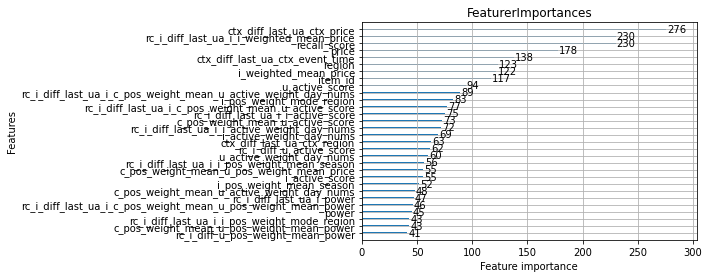

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,15))
lgb.plot_importance(lgb_ranker, max_num_features=30)
plt.title("FeaturerImportances")
plt.show()

In [ ]:
booster = lgb_ranker.booster_
importance = booster.feature_importance(importance_type='split')
feature_name = booster.feature_name()

# for (feature_name,importance) in zip(feature_name,importance):
#     print (feature_name,importance) 

fea_importance_df = pd.DataFrame({'feature_name':feature_name, 'feature_importance': importance})
# feature_importance.to_csv(os.path.join(save_dir, 'feature_importance.csv'),index=False)

In [ ]:
import seaborn as sns

In [ ]:
fea_importance_df = fea_importance_df.sort_values('feature_importance', ascending=[False])
fea_importance_df['feature_importance'] = fea_importance_df['feature_importance'] / fea_importance_df['feature_importance'].sum()

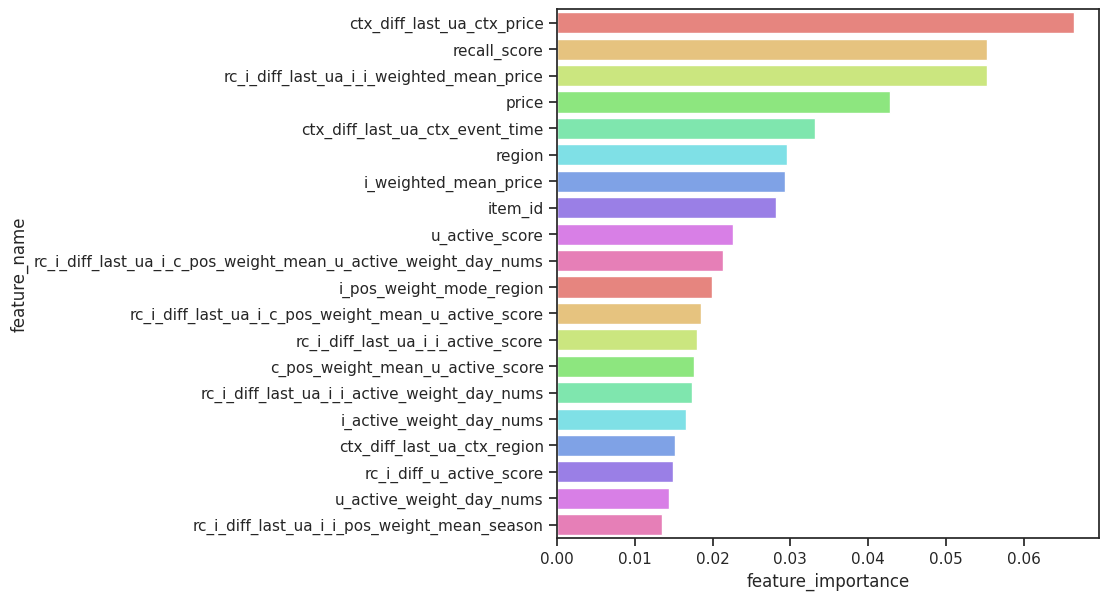

In [ ]:
plt.rcParams['figure.dpi'] = 100
sns.set_context({'figure.figsize':[7, 7]})
sns.set_theme(style='ticks')  
sns.barplot(y='feature_name', x='feature_importance', data=fea_importance_df[:20], palette=sns.hls_palette(10, l=.7, s=.9))
            # order=fea_importance_df[:20].sort_values('feature_importance', ascending=[False]).feature_name)

# plt.set_xticklabels(labels = ['file_id_tid_mean','api_LdrGetProcedureAddress','file_id_tid_max','file_id_tid_std','file_id_tid_min','api_LdrGetDllHandle','file_id_api_count','file_id_api_nunique','file_id_index_nunique','api_NtClose'],
#                                     rotation = 45,fontsize = 15) # 放大横轴坐标并逆时针旋转45°
# plt.set_yticklabels(labels = [0,500,1000,1500,2000,2500,3000,3500],fontsize = 15) # 放大纵轴坐标
# plt.xlabel('fea_name',fontsize=18) # 放大横轴名称
# plt.ylabel('fea_imp',fontsize=18) # 放大纵轴名称
